# NICOLAS LEGUIZAMON TALLER 5

# Redes neuronales profundas para clasificación de imagenes: aplicación 

En este taller va a utilizar las funciones que implementó en el taller anterior: "Taller4_RedesNeuronalesProfundas", y va a construir una red neuronal profunda, aplicandola a la clasificación de imagenes. 

El modelo se va a aplicar sobre las imagenes de ´gato, no-gato', y esperamos ver una mejoría en la precisión relativa (accuracy) con respecto a la regresión logística implementada anteriormente.  

**Tras este taller va a ser capaz de:**
- Construir y aplicar una red neuronal profunda para el aprendizaje supervisado. 


## 1 - Paquetes

Primero se deben importar todos los paquetes que se van a necesitar durante este taller.
- [numpy](www.numpy.org) paquete básico para ciencias computacionales con Python.
- [matplotlib](http://matplotlib.org) librería para graficar en Python.
- [h5py](http://www.h5py.org) paquete para interactuar con datos guardados como archivo H5.
- [PIL](http://www.pythonware.com/products/pil/) y [scipy](https://www.scipy.org/) usados para probar el modelo con imagenes propias al final del taller.
- dnn_app_utils provee las funciones implementadas en el taller anterior.

In [3]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # tamaño de las graficas por defecto
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1) # se utiliza para replicar las funciones aleatorias 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Conjunto de datos

Vamos a usar el mismo conjunto de datos del Taller 2 "RegresiónLogística". El modelo que construyó tenía un 70% de precisión de prueba (test) al clasificar imagenes de gatos y todo aquello que no era gato (no-gato). Ahora vamos a implementar un modelo de redes profundas, y esperamos que su desempeño sea mejor!

**Problema**: Dado el conjunto de datos ("data.h5") con:
    - un conjunto de datos de entrenamiento (CE) con imagenes etiquetadas como gato (1) y no-gato(0)
    - un conjunto de prueba (test) con imagenes etiquetadas como gato y no-gato
    - cada imagen es de tamaño (num_px, num_px, 3) donde 3 es para los canales (RGB).

A continuación exploramos el conjunto de datos. Cargue los datos ejecutando la celda abajo.

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
clases=["no-gato", "gato"]

El siguiente código muestra una imagen del conjunto de datos. Puede cambiar el índice y volver a ejecutar para cambiar de imagen.  

La imagen #200, es un 'gato'


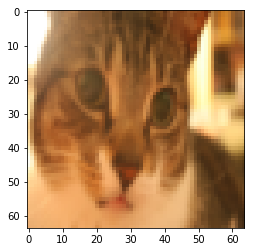

In [5]:
# Ejemplo de una imagen
indice = 200
plt.imshow(train_x_orig[indice])
print ("La imagen #" + str(indice) + ", es un '" + str(clases[np.squeeze(train_y[:, indice])]) + "'" )

In [6]:
# Explore los datos
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]

print ("Número de ejemplos de entrenamiento: m_train = " + str(m_train))
print ("Número de ejemplos de prueba: m_test = " + str(m_test))
print ("Cada imagen es de tamaño: (" + str(num_px) + ", " + str(num_px) + ", 3)")

print ("Dimensión del train_x_orig: " + str(train_x_orig.shape))
print ("Dimensión del train_y: " + str(train_y.shape))
print ("Dimensión del test_x_orig: " + str(test_x_orig.shape))
print ("Dimensión del test_y: " + str(test_y.shape))

Número de ejemplos de entrenamiento: m_train = 209
Número de ejemplos de prueba: m_test = 50
Cada imagen es de tamaño: (64, 64, 3)
Dimensión del train_x_orig: (209, 64, 64, 3)
Dimensión del train_y: (1, 209)
Dimensión del test_x_orig: (50, 64, 64, 3)
Dimensión del test_y: (1, 50)


**Salida esperada para m_train, m_test y tamaño de la imagen**: 
<table style="width:25%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> (64, 64, 3) </td> 
  </tr>
  
</table>


Como de costumbre, cambiamos las dimensiones (reshape) y estandarizamos las imagenes antes de alimentarlas a la red. 

In [7]:
# Cambiamos la dimensión de los ejemplos de entrenamiento y prueba
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # El "-1" hace que la función reshape() aplane (flatten) las restantes dimensiones
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Normalizamos los datos para tener valores entre 0 y 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("Dimensiones de train_x: " + str(train_x.shape))
print ("Dimensiones de test_x: " + str(test_x.shape))


Dimensiones de train_x: (12288, 209)
Dimensiones de test_x: (12288, 50)


$12,288$ equivale a $64 \times 64 \times 3$, el cual es el tamaño de un vector de imagen transformado.

## 3 - Arquitectura del modelo

Ahora es el momento de construir una red neuronal profunda para la clasificación de imagenes.

Va a construir dos modelos distintos:
- Una red neuronal de dos capas
- Una red neuronal profunda de L capas

Luego va a comparar el desempeño de los modelos, y va a intentar con distintos valores para $L$. 

Veamos las dos arquitecturas.

### 3.1 - Red neuronal de 2 capas

- El input es una imagen de dimensiones (64,64,3) que es aplanada a un vector de tamaño $(12288,1)$. 
- El vector correspondiente: $[x_0,x_1,...,x_{12287}]^T$ es multiplicado por una matriz de pesos $W^{[1]}$ de tamaño $(n^{[1]}, 12288)$.
- Le añade el intercepto o término de sesgo, y le aplica ReLU para conseguir el vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repite el mismo proceso.
- Multiplica el vector resultante por $W^{[2]}$ y le añade el sesgo. 
- Finalmente, toma el sigmoide del resultado. Si es mayor que 0.5, clasifica como de clase 1.

### 3.2 - Red neuronal profunda de L capas

- El input es una imagen de dimensiones (64,64,3) que es aplanada a un vector de tamaño $(12288,1)$. 
- El vector correspondiente: $[x_0,x_1,...,x_{12287}]^T$ es multiplicado por una matriz de pesos $W^{[1]}$, y le añade el sesgo $b^{[1]}$. Al resultado se le llama "unidad lineal".
- Luego, toma la ReLU para esta unidad. Este proceso se repite tantas veces como sea necesario para cada $(W^{[l]}, b^{[l]})$, dependiendo de la arquitectura del modelo.
- Finalmente, toma el sigmoide de la última unidad lineal. Si es mayor que 0.5, clasifica como de clase 1.

### 3.3 - Metodología general

Como es usual, seguirá una metodología de aprendizaje profundo para consturir el modelo:
    1. Inicialización de parámetros y definición de hiper-parámetros
    2. Bucle para el total de iteraciones (num_iterations):
        a. Propagación hacia delante
        b. Cálculo de la función de coste
        c. Retro-propagación
        d. Actualización de parámetros 
    4. En base a los parámetros aprendidos, predecir las etiquetas de clases


## 4 - Red neuronal de 2 capas

**Ejercicio**:  Utilice las funciones auxiliares que ha implementado en el taller anterior para construir una red de dos capas con la siguiente estructura: *LINEAL -> RELU -> LINEAL -> SIGMOIDE*. Las funciones que va a necesitar y sus entradas son:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [8]:
### DEFINICIÓN DE CONSTANTES (HIPER-PARÁMETROS) DEL MODELO ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [9]:
# FUNCIÓN A CALIFICAR: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implemente una red neuronal de dos capas: LINEAL->RELU->LINEAL->SIGMOIDE
    Input:
    X: datos de entrada de tamaño (n_x, número de ejemplos)
    Y: vector de etiquetas observadas de tamaño (1, número de ejemplos)
    layers_dims: dimensiones de las capas (n_x, n_h, n_y)
    num_iterations: número de iteraciones del bucle de optimización
    learning_rate: tasa de aprendizaje de la regla de actualización por G.D. 
    print_cost: si es verdadero "True", muestra el coste cada 100 iteraciones 
    Output:
    parameters: diccionario con W1, W2, b1, y b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              
    m = X.shape[1]                           
    (n_x, n_h, n_y) = layers_dims
    
    # Inicialice el diccionario de parametros, llamando una de las funciones que ya implementó
    ### EMPIEZE EL CÓDIGO AQUÍ ###  (≈ 1 línea de código)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    # Obtenga W1, b1, W2 y b2 del diccionario de parámetros.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Bucle (G.D.)
    for i in range(0, num_iterations):

        # Propagación hacia delante: LINEAL -> RELU -> LINEAL -> SIGMOIDE. Inputs: "X, W1, b1, W2, b2". Outputs: "A1, cache1, A2, cache2".
        ### EMPIEZE EL CÓDIGO AQUÍ ###  (≈ 2 líneas de código)
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
        ### TERMINE EL CÓDIGO AQUÍ ###
        
        # Calcule el coste
        ### EMPIEZE EL CÓDIGO AQUÍ ###  (≈ 1 línea de código)
        cost = compute_cost(A2,Y)
        ### TERMINE EL CÓDIGO AQUÍ ###
        
        # Inicialice la retro-propagación
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Retro-propagación. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; , dW1, db1; dA0 no es utilizado".
        ### EMPIEZE EL CÓDIGO AQUÍ ###  (≈ 2 líneas de código)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        ### TERMINE EL CÓDIGO AQUÍ ###
        
        # Iguale grads['dWl'] a dW1, grads['db1'] a db1, grads['dW2'] a dW2, grads['db2'] a db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Actualice los parámetros.
        ### EMPIEZE EL CÓDIGO AQUÍ ###  (1 línea de código)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### TERMINE EL CÓDIGO AQUÍ ###

        # Recupere W1, b1, W2, b2 de parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Imprima el coste cada 100 iteraciones
        if print_cost and i % 100 == 0:
            print("Coste tras la iteración {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # grafique el coste

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iteraciones')
    plt.title("Tasa de aprendizaje =" + str(learning_rate))
    plt.show()
    
    return parameters

Ejecute la siguente celda para aprender los parámetros. Asegúrese que su modelo corre bien: el coste debería decrecer. Puede tomar algunos minutos el ejecutar 2500 iteraciones. Revise que el "Coste tras la iteración 0" coincida con la salida esperada abajo, si no, haga click en el cuadrado de STOP (⬛) arriba en la barra del cuaderno para detener el proceso e intente encontrar su error.

Coste tras la iteración 0: 0.693049735659989
Coste tras la iteración 100: 0.6464320953428849
Coste tras la iteración 200: 0.6325140647912678
Coste tras la iteración 300: 0.6015024920354665
Coste tras la iteración 400: 0.5601966311605748
Coste tras la iteración 500: 0.5158304772764729
Coste tras la iteración 600: 0.4754901313943325
Coste tras la iteración 700: 0.43391631512257495
Coste tras la iteración 800: 0.40079775362038844
Coste tras la iteración 900: 0.3580705011323798
Coste tras la iteración 1000: 0.3394281538366413
Coste tras la iteración 1100: 0.30527536361962654
Coste tras la iteración 1200: 0.27491377282130164
Coste tras la iteración 1300: 0.2468176821061486
Coste tras la iteración 1400: 0.19850735037466108
Coste tras la iteración 1500: 0.17448318112556666
Coste tras la iteración 1600: 0.17080762978097128
Coste tras la iteración 1700: 0.11306524562164708
Coste tras la iteración 1800: 0.09629426845937153
Coste tras la iteración 1900: 0.08342617959726871
Coste tras la iteración

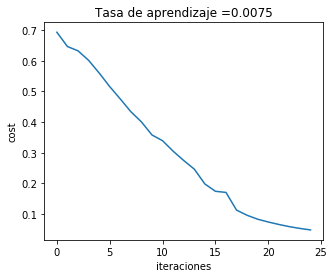

In [10]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Salida esperada**
<table> 
    <tr>
        <td> **Coste tras la iteración 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Coste tras la iteración 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Coste tras la iteración 2400**</td>
        <td> 0.048554785628770206 </td>
    </tr>
</table>

Nótese que gracias a la implementación vectorizada, el código no tarda demasiado en ejecutarse (de otro modo, podría haber llevado hasta 10 veces más tiempo).

Ahora puede usar los parametros entrenados para clasificar las imagenes del conjunto de datos. Para ver las predicciones de entrenamiento y prueba (test), ejecute la celda abajo.

In [11]:
predictions_train = predict(train_x, train_y, parameters)

Precisión: 0.9999999999999998


**Salida esperada**
<table> 
    <tr>
        <td> **Precisión**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [12]:
predictions_test = predict(test_x, test_y, parameters)

Precisión: 0.72


**Salida esperada**

<table> 
    <tr>
        <td> **Precisión**</td>
        <td> 0.72 </td>
    </tr>
</table>

**Nota**: Puede ver que si se ejecuta el modelo con menos iteraciones (e.g. 1500) se obtendría una mayor precisión de prueba. Esto se conoce como "early stopping" y es un criterio de parada, útil para prevenir el sobreajuste, que veremos más adelante. 

Muy bien! Parece que su modelo de red neuronal con 2 capas tiene un mejor desempeño (72%) que el de la regresión logística del Taller 2 (70%). Ahora vamos a ver si podemos mejorar los resultados con un modelo de $L$ capas.

## 5 - Red neuronal de L capas

**Ejercicio**:  Utilice las funciones auxiliares que ha implementado en el anterior taller para construir una red de L capas con la siguiente estructura: *[LINEAL -> RELU]$\times$(L-1) -> LINEAL -> SIGMOIDE*. Las funciones que va a necesitar y sus entradas son:

```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```


In [13]:
### CONSTANTES ###
layers_dims = [12288, 20, 7, 5, 1] #  Modelo de 4 capas

In [14]:
# FUNCIÓN A CALIFICAR: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implemente una red neuronal de L capas: [LINEAL->RELU]*(L-1)->LINEAL->SIGMOIDE
    Input:
    X: datos de entrada de tamaño (n_x, número de ejemplos)
    Y: vector de etiquetas observadas de tamaño (1, número de ejemplos)
    layers_dims: dimensiones de las capas (n_x, n_h, n_y)
    num_iterations: número de iteraciones del bucle de optimización
    learning_rate: tasa de aprendizaje de la regla de actualización por G.D. 
    print_cost: si es verdadero "True", muestra el coste cada 100 iteraciones 
    Output:
    parameters: diccionario con W1, W2, b1, y b2
    """

    np.random.seed(1)
    costs = []                         
    
    # Inicialización de parámetros. (≈ 1 linea de código)
    ### EMPIEZE EL CÓDIGO AQUÍ ### 
    parameters = initialize_parameters_deep(layers_dims)
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    # Bucle (G.D.)
    for i in range(0, num_iterations):

        # Propagación hacia delante: [LINEAL -> RELU]*(L-1) -> LINEAL -> SIGMOIDE.
        ### EMPIEZE EL CÓDIGO AQUÍ ###  (≈ 1 línea de código)
        AL, caches = L_model_forward(X, parameters) 
        ### TERMINE EL CÓDIGO AQUÍ ###
        
        # Calcule el coste.
        ### EMPIEZE EL CÓDIGO AQUÍ ###  (≈ 1 línea de código)
        cost = compute_cost(AL, Y)
        ### TERMINE EL CÓDIGO AQUÍ ###
    
        # Retro-propagación.
        ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
        grads = L_model_backward(AL, Y, caches)
        ### TERMINE EL CÓDIGO AQUÍ ###
 
        # Actualize los parámetros
        ### EMPIEZE EL CÓDIGO AQUÍ ###  (≈ 1 línea de código)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### TERMINE EL CÓDIGO AQUÍ ###
                
        # Imprime el coste cada 100 iteraciones
        if print_cost and i % 100 == 0:
            print ("Coste tras la iteración %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # grafique el coste
    plt.plot(np.squeeze(costs))
    plt.ylabel('Coste')
    plt.xlabel('Iteraciones')
    plt.title("Tasa de aprendizaje =" + str(learning_rate))
    plt.show()
    
    return parameters

Ahora va a entrenar el modelo como una red neuronal de 4 capas. 

Ejecute la siguente celda para aprender los parámetros. Asegúrese que su modelo corre bien: el coste debería decrecer. Puede tomar algunos minutos el ejecutar 2500 iteraciones. Revise que el "Coste tras la iteración 0" coincida con la salida esperada abajo, si no, haga click en el cuadrado de STOP (⬛) arriba en la barra del cuaderno para detener el proceso e intente encontrar su error.

Coste tras la iteración 0: 0.771749
Coste tras la iteración 100: 0.672053
Coste tras la iteración 200: 0.648263
Coste tras la iteración 300: 0.611507
Coste tras la iteración 400: 0.567047
Coste tras la iteración 500: 0.540138
Coste tras la iteración 600: 0.527930
Coste tras la iteración 700: 0.465477
Coste tras la iteración 800: 0.369126
Coste tras la iteración 900: 0.391747
Coste tras la iteración 1000: 0.315187
Coste tras la iteración 1100: 0.272700
Coste tras la iteración 1200: 0.237419
Coste tras la iteración 1300: 0.199601
Coste tras la iteración 1400: 0.189263
Coste tras la iteración 1500: 0.161189
Coste tras la iteración 1600: 0.148214
Coste tras la iteración 1700: 0.137775
Coste tras la iteración 1800: 0.129740
Coste tras la iteración 1900: 0.121225
Coste tras la iteración 2000: 0.113821
Coste tras la iteración 2100: 0.107839
Coste tras la iteración 2200: 0.102855
Coste tras la iteración 2300: 0.100897
Coste tras la iteración 2400: 0.092878


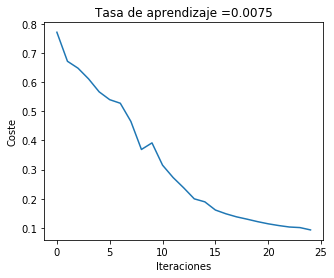

In [15]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Salida esperada**
<table> 
    <tr>
        <td> **Coste tras la iteración 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Coste tras la iteración 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Coste tras la iteración 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [16]:
pred_train = predict(train_x, train_y, parameters)

Precisión: 0.9856459330143539


**Salida esperada**

<table>
    <tr>
    <td>
    **Precisión de entrenamiento**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [17]:
pred_test = predict(test_x, test_y, parameters)

Precisión: 0.8


**Salida esperada**

<table> 
    <tr>
        <td> **Precisión de prueba**</td>
        <td> 0.8 </td>
    </tr>
</table>

Muy bien! Parece que la red neuronal de 4 capas tiene mejor desempeño (80%) que la red de 2 capas (72%) sobre el mismo conjunto de datos. 

Este es un buen desempeño! 

En las próximas clases veremos cómo podemos obtener una precisión aun mayor, buscando de manera sistemática mejores estimaciones para los hiper-parámetros (tasa de parendizaje, tamaño de las capas, número de iteraciones, entre otros). 

##  6) Análisis de resultados

Primero analicemos el error de manera manual. Revisemos algunas de las imagenes que el modelo de L capas etiquetó incorrectamente. Ejecute la celda abajo para visualizar algunos de estos errores. 

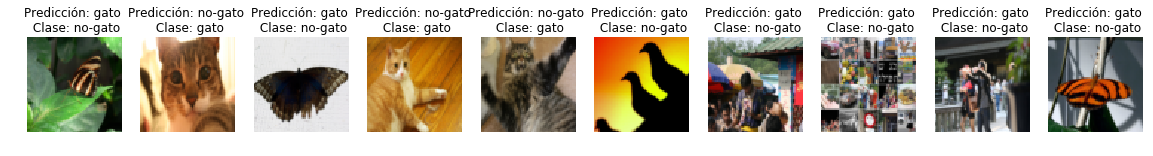

In [18]:
print_mislabeled_images(clases, test_x, test_y, pred_test)

**Las distintas imagenes sobre las que el modelo tiende a equivocarse incluyen:** 
- El cuerpo del gato está en una posición inusual
- El gato aparece contra el fondo de un color similar
- Color y especie de gato inusual 
- Angulo de la cámara inusual
- Imagen muy/poco brillante
- Escala de la variación (el gato aparece muy grande o muy pequeño en la imagen) 

## 7) Prueba con su propia imagen ##

Ahora puede utilizar su propia imagen para probar el modelo. Para hacerlo agregue su(s) imagen(es) al directorio de este cuaderno en la carpeta "images", cambie el nombre de la (s) imagen(es) en el código siguiente, y compruebe si el algoritmo acierta (1=gato, 0=no-gato). 

C:\Users\Nicolas L\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\Nicolas L\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
C:\Users\Nicolas L\Documents\PERSONAL NLR\UNIVERSIDAD\S22018\ANALISIS DE DATOS 2\taller 5\dnn_app_utils_v3.py:246: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print("Precisión: "  + str(np.sum((p == y)/m)))


Precisión: 0.0
y = 0, el modelo predice que es una imagen de un "no-gato".


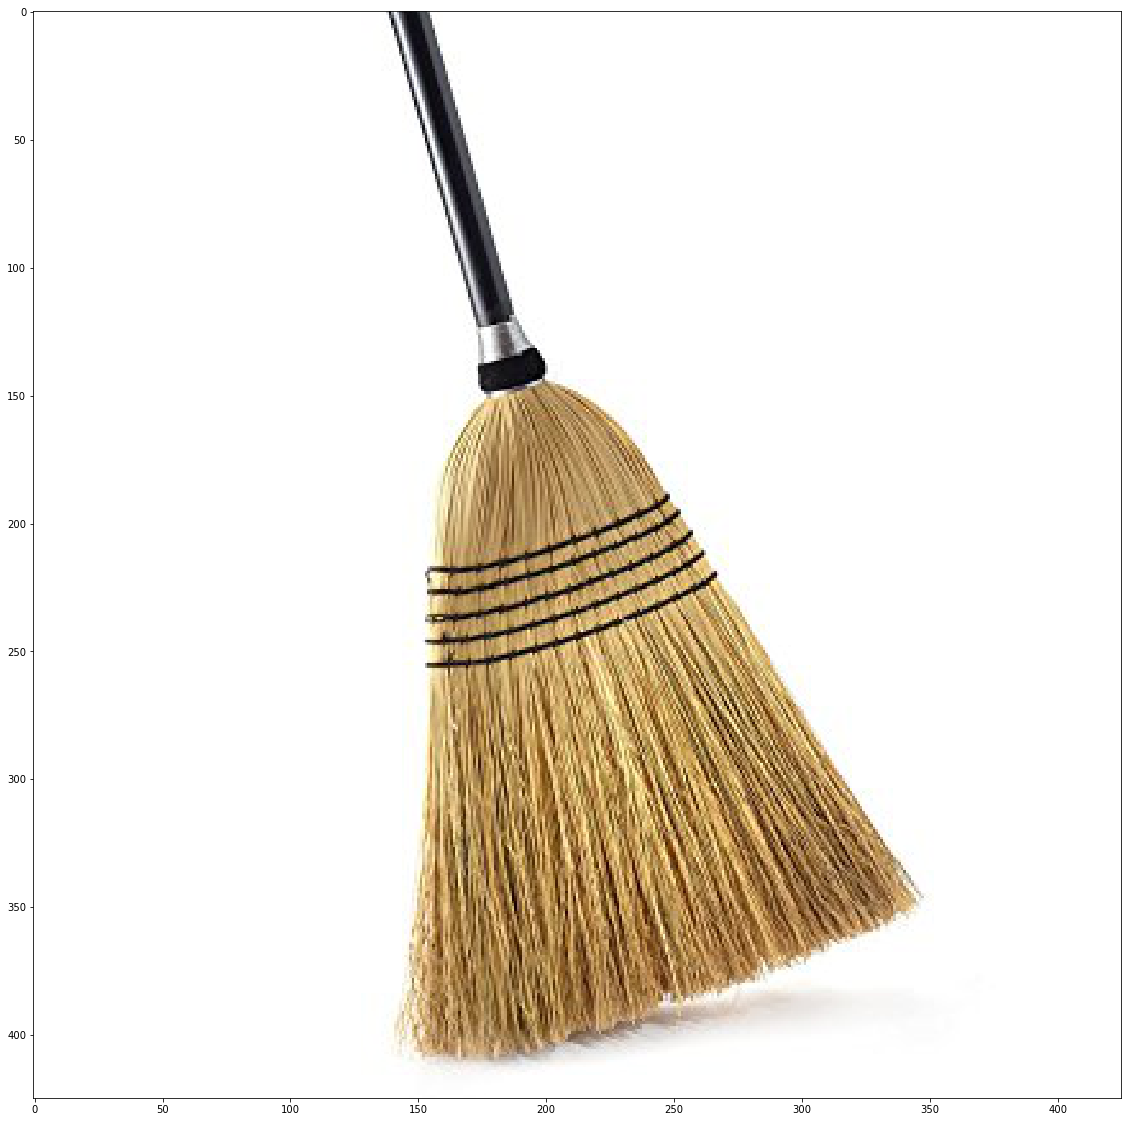

In [21]:
### EMPIEZE EL CÓDIGO AQUÍ ### 
mi_imagen = 'broom.jpg'  # el nombre debe coincidir con el de su imagen
mi_etiqueta = 'gato'  # la clase verdadera para su imagen (1 -> gato, 0 -> no-gato)
## TERMINE EL CÓDIGO AQUÍ ##

fname = "images/" + mi_imagen
image = np.array(ndimage.imread(fname, flatten=False))
mi_imagen = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
mi_imagen = mi_imagen/255.
mi_imagen_pred = predict(mi_imagen, mi_etiqueta, parameters)

plt.imshow(image)
print("y = " + str(int(np.squeeze(mi_imagen_pred))) + ", el modelo predice que es una imagen de un \"" + clases[int(np.squeeze(mi_imagen_pred))]+  "\".")


C:\Users\Nicolas L\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\Nicolas L\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
C:\Users\Nicolas L\Documents\PERSONAL NLR\UNIVERSIDAD\S22018\ANALISIS DE DATOS 2\taller 5\dnn_app_utils_v3.py:246: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print("Precisión: "  + str(np.sum((p == y)/m)))


Precisión: 0.0
y = 1, el modelo predice que es una imagen de un "gato".


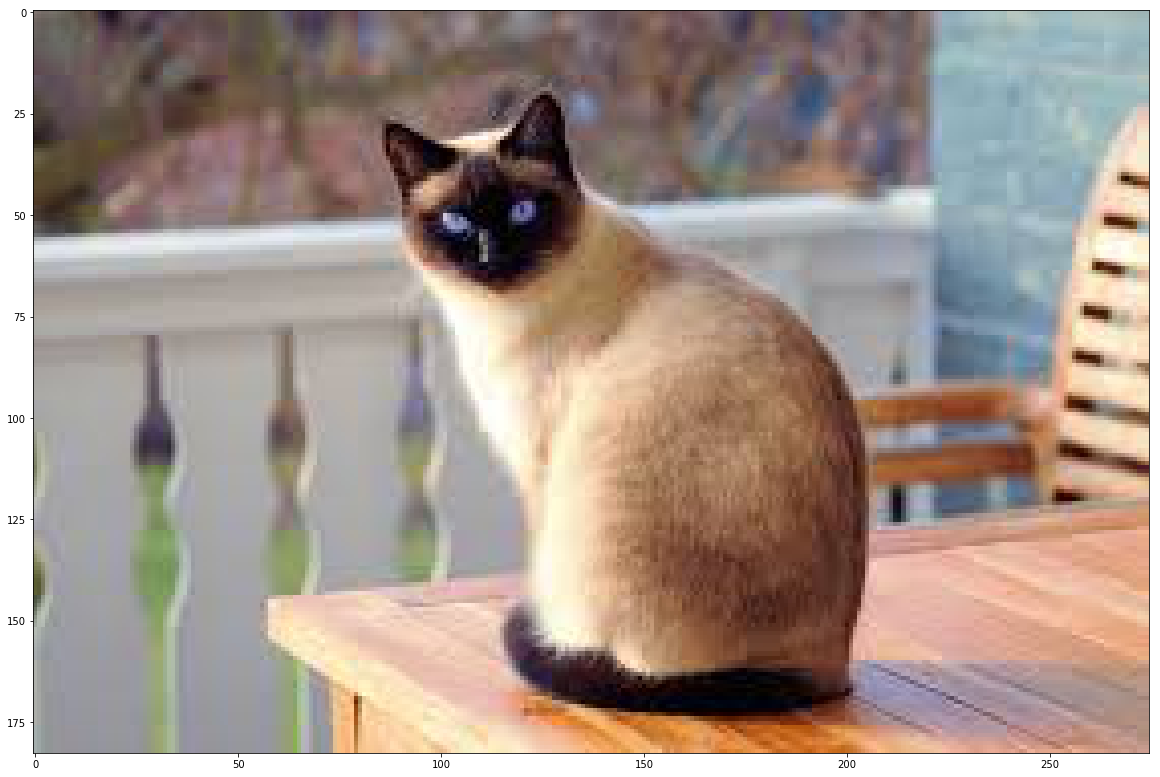

In [22]:
### EMPIEZE EL CÓDIGO AQUÍ ### 
mi_imagen = 'cat.JPG'  # el nombre debe coincidir con el de su imagen
mi_etiqueta = 'gato'  # la clase verdadera para su imagen (1 -> gato, 0 -> no-gato)
## TERMINE EL CÓDIGO AQUÍ ##

fname = "images/" + mi_imagen
image = np.array(ndimage.imread(fname, flatten=False))
mi_imagen = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
mi_imagen = mi_imagen/255.
mi_imagen_pred = predict(mi_imagen, mi_etiqueta, parameters)

plt.imshow(image)
print("y = " + str(int(np.squeeze(mi_imagen_pred))) + ", el modelo predice que es una imagen de un \"" + clases[int(np.squeeze(mi_imagen_pred))]+  "\".")


C:\Users\Nicolas L\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\Nicolas L\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
C:\Users\Nicolas L\Documents\PERSONAL NLR\UNIVERSIDAD\S22018\ANALISIS DE DATOS 2\taller 5\dnn_app_utils_v3.py:246: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print("Precisión: "  + str(np.sum((p == y)/m)))


Precisión: 0.0
y = 1, el modelo predice que es una imagen de un "gato".


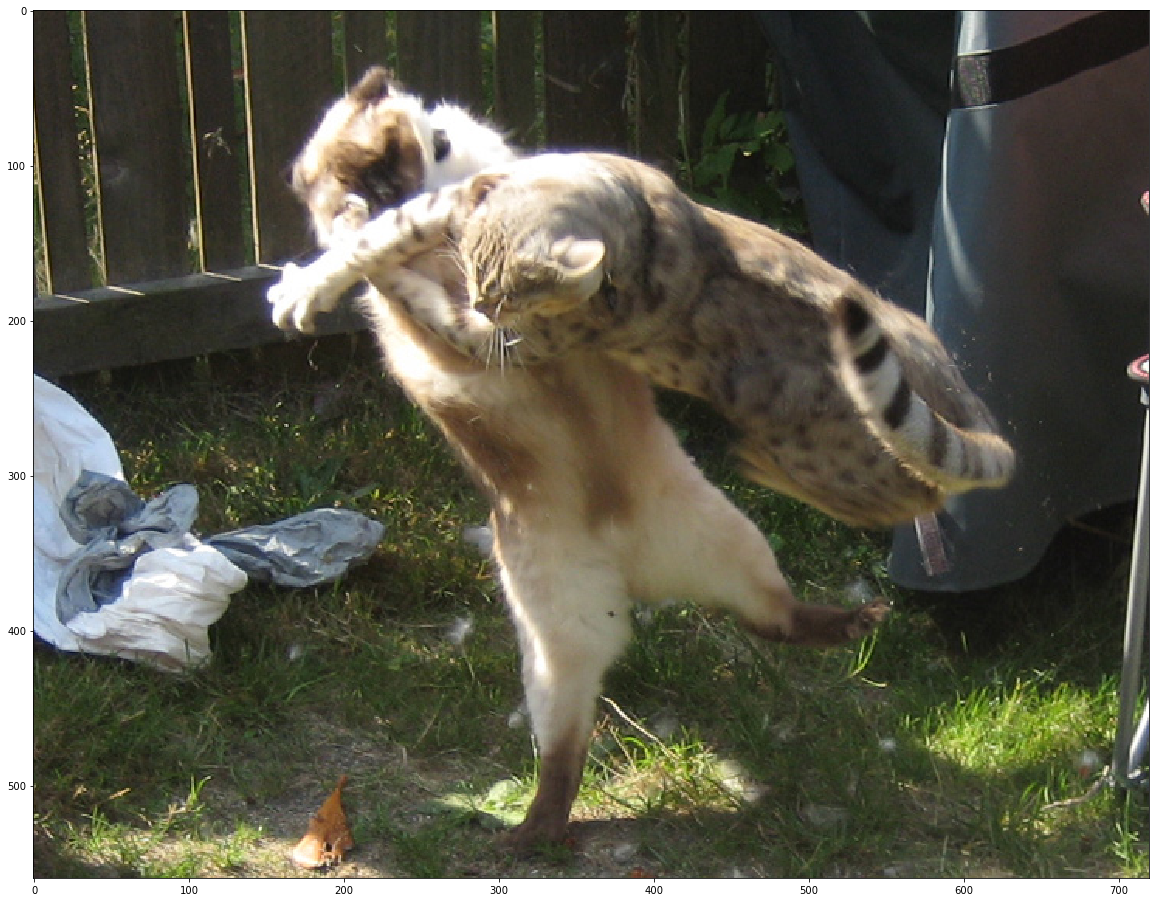

In [23]:
### EMPIEZE EL CÓDIGO AQUÍ ### 
mi_imagen = 'cat2.jpg'  # el nombre debe coincidir con el de su imagen
mi_etiqueta = 'no-gato'  # la clase verdadera para su imagen (1 -> gato, 0 -> no-gato)
## TERMINE EL CÓDIGO AQUÍ ##

fname = "images/" + mi_imagen
image = np.array(ndimage.imread(fname, flatten=False))
mi_imagen = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
mi_imagen = mi_imagen/255.
mi_imagen_pred = predict(mi_imagen, mi_etiqueta, parameters)

plt.imshow(image)
print("y = " + str(int(np.squeeze(mi_imagen_pred))) + ", el modelo predice que es una imagen de un \"" + clases[int(np.squeeze(mi_imagen_pred))]+  "\".")


Efectivamente, el algoritmo funciona bastante bien hasta en el caso de una posición inusual del gato.